In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel("bitaksi_RFM_Segmentasyonu_Dummy_Data_1000.xlsx")
df.head()

,Customer ID,Last Transaction Date,Frequency (Usage in Last 12 Months),Total Spending (TL)
0,1,2024-04-25,50,1748
1,2,2024-09-19,37,4055
2,3,2024-04-10,39,2647
3,4,2024-04-23,6,3980
4,5,2024-07-30,4,2907


# Assign RFM Scores

### Recency (R) : Segment customers into 5 groups based on the number of days since their last ride.

In [4]:
import datetime as dt

In [5]:
# calculate recency

today = dt.datetime(2024, 12, 31) # assume today is the last day of 2024
df['Last Transaction Date'] = pd.to_datetime(df['Last Transaction Date'])
df['Recency'] = (today - df['Last Transaction Date']).dt.days

df['Recency'].head()

0    250
1    103
2    265
3    252
4    154
Name: Recency, dtype: int64

In [6]:
# sorting the 'Recency' column

df.sort_values(by='Recency', ascending=False).head(10)

print(df.sort_values(by='Recency', ascending=False).head(10).to_string(index=False))


 Customer ID Last Transaction Date  Frequency (Usage in Last 12 Months)  Total Spending (TL)  Recency
         871            2023-12-11                                   24                 2420      386
         222            2023-12-11                                   41                 1093      386
         885            2023-12-11                                   31                 2077      386
         475            2023-12-12                                   42                 2346      385
         170            2023-12-13                                    4                 1732      384
         273            2023-12-13                                   14                 1860      384
         540            2023-12-14                                   21                  887      383
          29            2023-12-14                                   19                 2275      383
         354            2023-12-14                                   18           

#### Recency thresholds (days since last ride) will be as below:

Score 5:   0 –  83 days

Score 4:  84 – 130 days

Score 3: 131 – 209 days

Score 2: 210 – 330 days

Score 1: 331 – 551 days



In [7]:
# Recency (R) : Segment customers into 5 groups based on the number of days since their last ride.

df['R_Score'] = pd.qcut(df['Recency'], q=5, labels=[5, 4, 3, 2, 1])

df[['Customer ID', 'Recency', 'R_Score']].head()

df_sorted_oldest = df.sort_values('Recency', ascending=False)

print(df_sorted_oldest[['Customer ID', 'Recency', 'R_Score']].head().to_string(index=False))

 Customer ID  Recency R_Score
         871      386       1
         222      386       1
         885      386       1
         475      385       1
         170      384       1


### Frequency (F) : Segment customers into 5 groups based on their total ride frequency.

In [8]:
df['F_Score'] = pd.qcut(df['Frequency (Usage in Last 12 Months)'], 5, labels=[1, 2, 3, 4, 5])

df[['Customer ID', 'Frequency (Usage in Last 12 Months)', 'F_Score']].head()        # preview
df['F_Score'].value_counts().sort_index()               # counts per score


F_Score
1    215
2    198
3    194
4    212
5    181
Name: count, dtype: int64

#### Frequency thresholds:

Score 5: 42 – 50 rides

Score 4: 32 – 41 rides

Score 3: 23 – 31 rides

Score 2: 12 – 22 rides

Score 1: 1 – 11 rides



In [9]:
# Show min, max, and customer count for each F_Score bucket

df.groupby('F_Score')['Frequency (Usage in Last 12 Months)'].agg(['min', 'max', 'count']).sort_index()

/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/3888657401.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('F_Score')['Frequency (Usage in Last 12 Months)'].agg(['min', 'max', 'count']).sort_index()


,min,max,count
F_Score,,,
1,1,11,215
2,12,22,198
3,23,31,194
4,32,41,212
5,42,50,181


### Monetary (M) : Segment customers into 5 groups based on their total spending. Higher values indicate higher scores.

In [10]:
df['M_Score'] = pd.qcut(df['Total Spending (TL)'], 5, labels=[1, 2, 3, 4, 5])

df[['Customer ID', 'Total Spending (TL)', 'M_Score']].head()      # preview
df['M_Score'].value_counts().sort_index() 

M_Score
1    200
2    200
3    200
4    200
5    200
Name: count, dtype: int64

In [11]:
df.groupby('M_Score')['Total Spending (TL)'] \
  .agg(['min', 'max', 'count']) \
  .sort_index()

/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/240070586.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('M_Score')['Total Spending (TL)'] \


,min,max,count
M_Score,,,
1,55,1132,200
2,1135,2077,200
3,2082,3117,200
4,3123,4048,200
5,4050,4991,200


# Analyze the Segments <a id="analyze-the-segments"></a>

## Identify the most valuable segments.

In [12]:
# Combine the scores into 3-digit RFM code. Customers who score '555' will be the best customers.

df['RFM_Score'] = (
    df['R_Score'].astype(str) +
    df['F_Score'].astype(str) +
    df['M_Score'].astype(str)
)

df['RFM_Score'].head()

0    252
1    445
2    243
3    214
4    413
Name: RFM_Score, dtype: object

### Customers who scored 5 in all three segments will show '555'. Let's call them 'champions'. Those who have any two 5's and one 4 will be 'loyal_big_spenders'. Lastly, those whose all digits are ≥4 will be named 'high_value_cluster'.

In [13]:
# Champions
champions = df[df['RFM_Score'] == '555']

# Loyal Big-Spenders (any two 5’s, one 4)
loyal_big_spenders = df[df['RFM_Score'].isin(['554','545','455','544'])]

# High-Value Loyalists (all digits ≥4)
high_value_cluster = df[df['RFM_Score'].str.match(r'^[45][45][45]$')]


In [14]:
cols = ['Customer ID', 'Recency', 'Frequency (Usage in Last 12 Months)', 'Total Spending (TL)', 'RFM_Score']
champions[cols].head(10)

,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
130,131,77,49,4166,555
249,250,83,46,4947,555
460,461,48,47,4144,555
553,554,73,47,4590,555
754,755,45,42,4373,555
830,831,35,44,4741,555


In [15]:
segments = [
    champions.assign(Segment='Champions'),
    loyal_big_spenders.assign(Segment='Loyal Big-Spenders'),
    high_value_cluster.assign(Segment='High-Value Cluster')
]

combined = pd.concat(segments, ignore_index=True)

cols = ['Segment', 'Customer ID', 'Recency', 'Frequency (Usage in Last 12 Months)', 'Total Spending (TL)', 'RFM_Score']

combined[cols].head(30)


,Segment,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
0,Champions,131,77,49,4166,555
1,Champions,250,83,46,4947,555
2,Champions,461,48,47,4144,555
3,Champions,554,73,47,4590,555
4,Champions,755,45,42,4373,555
5,Champions,831,35,44,4741,555
6,Loyal Big-Spenders,23,92,49,3974,554
7,Loyal Big-Spenders,78,35,37,3772,544
8,Loyal Big-Spenders,108,37,50,3961,554
9,Loyal Big-Spenders,115,86,33,3709,544


/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/2385694523.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/2385694523.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/2385694523.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/2385694523.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

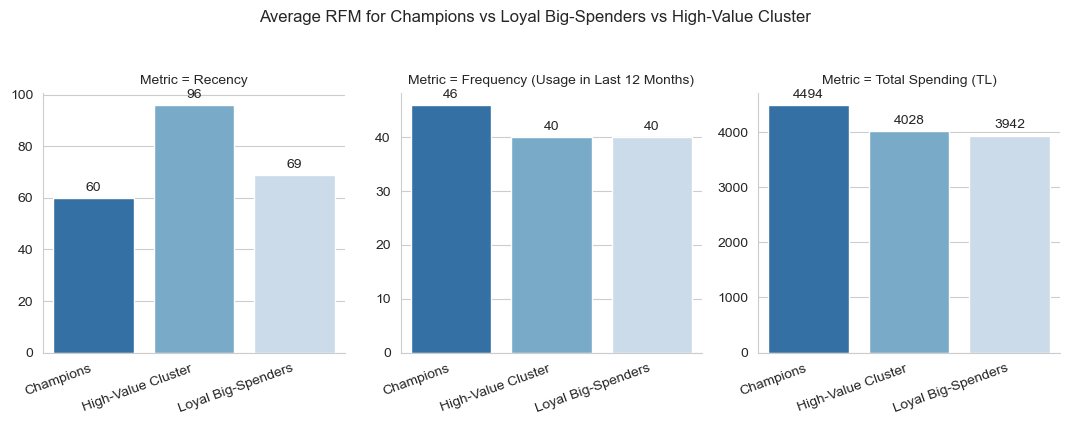

In [16]:
# plot

metrics = ['Recency', 'Frequency (Usage in Last 12 Months)', 'Total Spending (TL)']

seg_mean = (combined.groupby('Segment')[metrics]
            .mean()
            .round(0).astype(int)
            .reset_index()
            .melt(id_vars='Segment',
                  var_name='Metric', value_name='Mean'))

sns.set_style('whitegrid')

g = sns.catplot(
    data=seg_mean,
    x='Segment', y='Mean',
    col='Metric', kind='bar',
    palette='Blues_r',
    sharey=False, height=4, aspect=0.9
)

g.fig.suptitle('Average RFM for Champions vs Loyal Big-Spenders vs High-Value Cluster', y=1.05)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%d', padding=3)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


## Determine the characteristics of low-value segments.

### Criteria for low value segments will be that they are those whose overall RFM score is 222 or lower (e.g., 111, 122, 212).

In [17]:
low_value = df[
    (df['R_Score'].astype(int) <= 2) &   # not recent
    (df['F_Score'].astype(int) <= 2) &   # ride rarely
    (df['M_Score'].astype(int) <= 2)     # spend little
]

len(low_value)

65

In [18]:
low_value[['Customer ID',
           'Recency',
           'Frequency (Usage in Last 12 Months)',
           'Total Spending (TL)',
           'RFM_Score']].head()


,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
44,45,316,14,1176,222
56,57,271,12,782,221
74,75,325,21,929,121
105,106,355,15,1563,122
125,126,332,17,1018,121


In [19]:

low_stats = (
    low_value[['Recency',
               'Frequency (Usage in Last 12 Months)',
               'Total Spending (TL)']]
      .agg(['min', 'max', 'mean', 'count'])
      .round(0).astype(int)
      .T[['min', 'max', 'mean', 'count']]
)

print(low_stats)


                                     min   max  mean  count
Recency                              248   384   319     65
Frequency (Usage in Last 12 Months)    2    22    12     65
Total Spending (TL)                   55  2048  1042     65


### Characteristics of low-value segments:

- Recency for these users shows 8–13 months. 

- Frequency is between 2–22 (avg 1 ride/month).

- Lifetime spend per user is between ₺55 and ₺2 048 (mean = ₺1 042), well below core segments.

- In short, these customers were lightly engaged and have been dormant for nearly a year, making them ideal targets for a low-cost win-back or removal from expensive marketing lists.

/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/2779663381.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=plot_df,


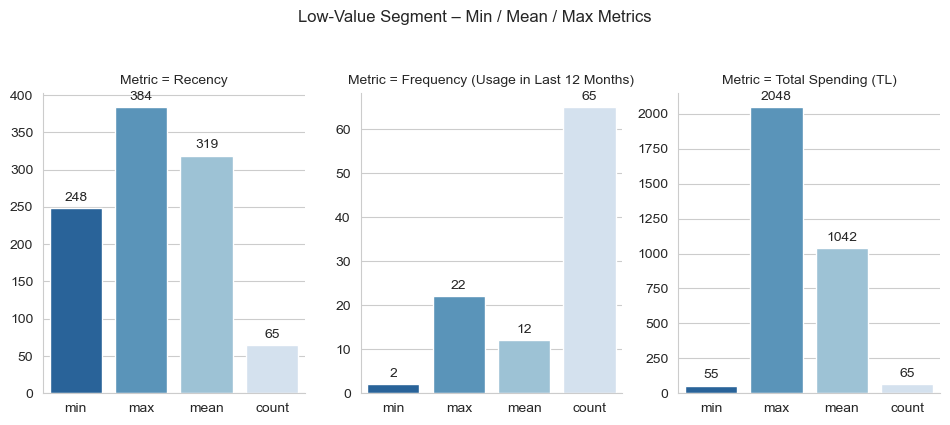

In [20]:
plot_df = (low_stats.reset_index()
                     .melt(id_vars='index',
                           var_name='Statistic',
                           value_name='Value')
                     .rename(columns={'index':'Metric'}))

sns.set_style('whitegrid')
g = sns.catplot(data=plot_df,
                x='Statistic', y='Value',
                col='Metric', kind='bar',
                palette='Blues_r',
                sharey=False,           
                height=4, aspect=0.8)

g.fig.suptitle('Low-Value Segment – Min / Mean / Max Metrics', y=1.05)

for ax in g.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%d', padding=3)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

## Highlight segments with growth potential.

### Segment #1 - "Potential Loyalists"

Those will be the customers who ride recently and fairly often but haven’t started spending big yet. Therefore, users whose R-score is 4-5 (recent), whose F-score is ≥ 3 (decent usage), and whose M-score is ≤ 3 (mid-/low spend) will be targeted. The idea here is to find people who have ridden recently, who ride fairly often, and to make them spend more than they usually do.

In [21]:
potential_loyalists = df[
    (df['R_Score'].astype(int) >= 4) &          
    (df['F_Score'].astype(int) >= 3) &         
    (df['M_Score'].astype(int) <= 3)            
]

cols = ['Customer ID', 'Recency',
        'Frequency (Usage in Last 12 Months)',
        'Total Spending (TL)', 'RFM_Score']
potential_loyalists[cols].head()  



,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
7,8,163,49,2407,453
14,15,61,43,1249,552
15,16,168,28,2429,433
16,17,142,32,394,441
17,18,161,39,2406,443


In [22]:
print("Potential Loyalists:", len(potential_loyalists))

Potential Loyalists: 134


### Why do Potential Loyalists matter?

- They’re active and forming a habit (high R, good F).

- Spending is still moderate (low M) → plenty of headroom for upsell.

- Timely incentives (loyalty points, ride bundles) can nudge them into the high-value “Loyal Big-Spender” tier.

### Segment #2 - "New Customers"

This segment includes those who are recent, ride rarely so far, and spend low.

In [23]:
new_customers = df[
    (df['R_Score'].astype(int) == 5) &
    (df['F_Score'].astype(int) <= 2) &
    (df['M_Score'].astype(int) <= 2)
]

cols = ['Customer ID', 'Recency',
        'Frequency (Usage in Last 12 Months)',
        'Total Spending (TL)', 'RFM_Score']
new_customers[cols].head()

,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
37,38,53,15,1957,522
43,44,32,20,873,521
61,62,36,15,1484,522
69,70,87,3,356,511
104,105,57,22,831,521


In [24]:
print("New Customers:", len(new_customers))

New Customers: 31


### Why do New Customers matter?

- Retention is cheapest now: a small welcome bonus can turn a one-off rider into a regular user.

- Early re-engagement multiplies lifetime value. Returning within the first month often increases eventual spend.

- A smooth first-ride experience locks in trust and referrals, reducing future acquisition costs.

### Segment #3 - "Promising"

These are the customers who have recently used the app and already taken a few rides, but whose spend is still relatively low.

In [25]:
promising = df[
    (df['R_Score'].astype(int) >= 4) & 
    (df['F_Score'].astype(int) <= 3) &  
    (df['M_Score'].astype(int) <= 2)
]

cols = ['Customer ID', 'Recency',
        'Frequency (Usage in Last 12 Months)',
        'Total Spending (TL)', 'RFM_Score']
promising[cols].head()

,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
24,25,140,8,1705,412
37,38,53,15,1957,522
38,39,127,26,480,431
43,44,32,20,873,521
55,56,134,28,534,431


In [26]:
print("Promising:", len(promising))

Promising: 92


### Why do New Customers matter?

- Early habit signals – they’ve come back for a second or third ride, so adoption is under way.

- Low current spend – plenty of room to grow basket size with ride bundles or tiered loyalty perks.

- Easier lift than brand-new users – they already recognise the value proposition; we are nudging frequency and spend, not teaching the basics.

### Plot the Mean R_Score, F_Score, and M_Score, Segment by Segment:

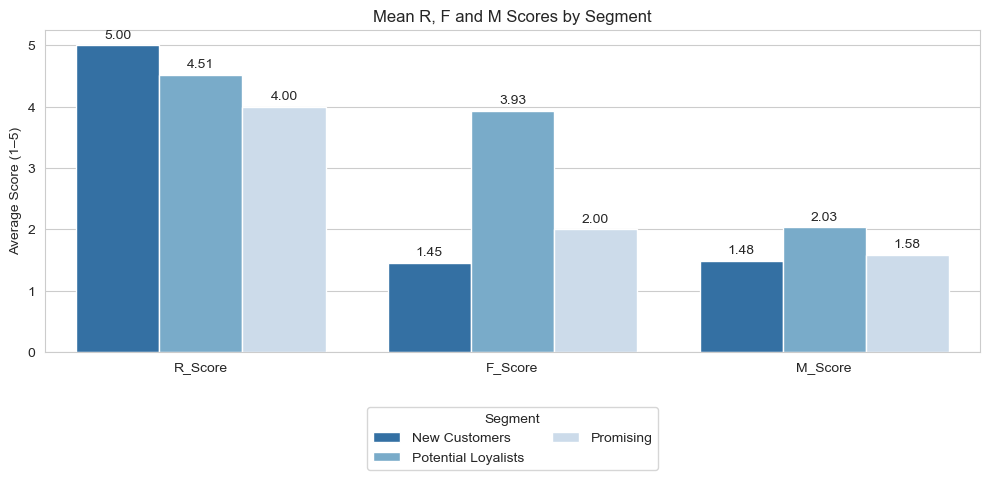

In [27]:
def label_segment(row):
    r, f, m, rfm = row['R_Score'], row['F_Score'], row['M_Score'], row['RFM_Score']
    if r==5 and f==5 and m==5: return 'Champions'
    if rfm in ['554','545','544','455']: return 'Loyal Big-Spenders'
    if r==5 and f<=2 and m<=2: return 'New Customers'
    if r>=4 and f>=3 and m<=3: return 'Potential Loyalists'
    if r>=4 and f==2 and m<=2: return 'Promising'
    if r<=3 and (f>=3 or m>=3): return 'At-Risk'
    return 'Others'

df['Segment'] = df.apply(label_segment, axis=1)

score_means = (df.groupby('Segment')[['R_Score', 'F_Score', 'M_Score']]
                 .apply(lambda s: s.astype(int).mean())  
                 .reset_index()
                 .melt(id_vars='Segment',
                       var_name='Metric',
                       value_name='Mean'))

score_means = score_means[score_means['Segment'].isin([
    'All Users', 'Promising', 'Potential Loyalists', 'New Customers'
])]

# 3) Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(data=score_means,
            x='Metric', y='Mean', hue='Segment',
            palette='Blues_r', ax=ax)

ax.set_title('Mean R, F and M Scores by Segment')
ax.set_ylabel('Average Score (1–5)')
ax.set_xlabel('')

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.2f', padding=3)

ax.legend(title='Segment',
          loc='upper center',
          bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()
plt.show()


# Step 2: Data-Driven Insights

Before we start our suggestions, let's compare the R_score, F_score, and M_score of the segments so that we are backing up our suggestions with our findings. For example, we will not send push notifications such as "We miss you" to our high-value or emerging customers right off the bat. However, we'll do that for our churned / low-value customers. Let's take a look:

## 1. Which segment represents the most valuable customers? Why?

In order to decide which segment represents the most valuable customers, we first need to look at the top segments and compare them. While champions bring the most value per user, they are very few (6 people), and there are not many possibilities to upsell because they are already using the app to the maximum. Instead, if we shift our focus to loyal big spenders (27), we see that much of our revenue are already coming from them, and we have the potential to turn them into champions!

Let's compare these segments and understand why we should tag loyal big spenders as the most valuable customers.

In [28]:
# Champions = 555
champions = df[
    (df['R_Score'].astype(int) == 5) &
    (df['F_Score'].astype(int) == 5) &
    (df['M_Score'].astype(int) == 5)
]

# Loyal Big-Spenders = any two 5s + one 4
loyal_codes = ['554', '545', '544', '455']
loyal_big_spenders = df[df['RFM_Score'].isin(loyal_codes)]

# KPI comparison
summary = pd.DataFrame({
    'Metric': ['Customer count',
               'Total revenue (TL)',
               'Revenue per customer (TL)'],
    'Champions': [
        int(len(champions)),
        int(champions['Total Spending (TL)'].sum()),
        int(champions['Total Spending (TL)'].mean())
    ],
    'Loyal Big-Spenders': [
        int(len(loyal_big_spenders)),
        int(loyal_big_spenders['Total Spending (TL)'].sum()),
        int(loyal_big_spenders['Total Spending (TL)'].mean())
    ]
})

print(summary.to_string(index=False))



                   Metric  Champions  Loyal Big-Spenders
           Customer count          6                  27
       Total revenue (TL)      26961              106433
Revenue per customer (TL)       4493                3941


/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/1675431350.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=plot_df,


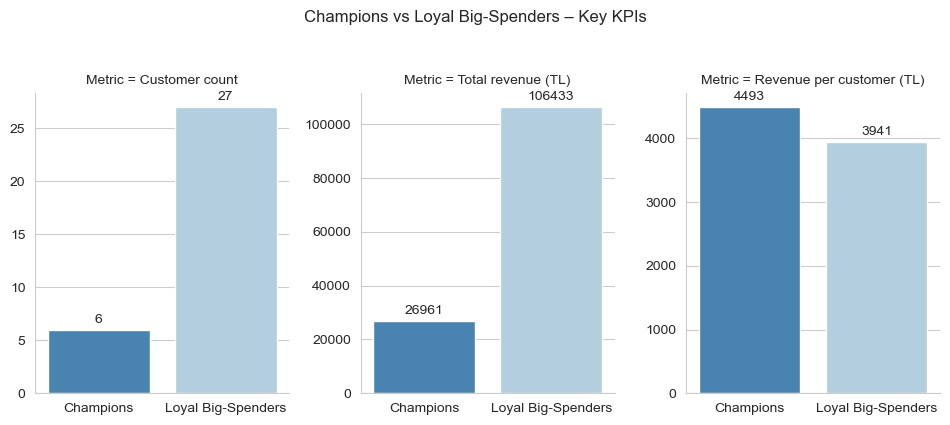

In [29]:
# plot 
plot_df = summary.melt(id_vars='Metric',
                       var_name='Segment',
                       value_name='Value')

g = sns.catplot(data=plot_df,
                x='Segment', y='Value',
                col='Metric', kind='bar',
                palette='Blues_r',
                sharey=False, height=4, aspect=0.8)

g.fig.suptitle('Champions vs Loyal Big-Spenders – Key KPIs', y=1.05)

for ax in g.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f', padding=3)
    ax.set_xlabel('')           
    ax.set_ylabel('')           

plt.tight_layout()
plt.show()


As seen clearly in the graphs above, the difference between the revenue per customer between Champions and Loyal Big-Spenders is not that much, whereas the headcount of loyal big spenders quadruples that of champions. In addition, the total revenue the loyal big spenders bring is almost four times more than that of champions. Imagine if we can convert at least some of them to champions, that would be very profitable for the business.

## 2. Which segment requires immediate action to prevent churn?

Let's call this segment as "At-risk". Those are the users whose R_score is low (R ≤ 2) but who were formerly high-frequency or high-spend (F_score ≥ 3 or M_score ≥ 3). They used to be valuable but haven’t opened the app for months.

Why are they urgent? They’re slipping away with the largest potential revenue haircut because their historical spend/frequency is high. Winning them back is cheaper than replacing them with new acquisitions.



In [30]:
at_risk = df[
    (df['R_Score'].astype(int) <= 3) &        
    (
        (df['F_Score'].astype(int) >= 3) |    
        (df['M_Score'].astype(int) >= 3)      
    )
]

len(at_risk)          # count


497

Now, let's compare them to all other users.

In [31]:
others = df.drop(at_risk.index)

# KPI comparison
summary = pd.DataFrame({
    'Metric': ['Customer count', 'Total revenue (TL)', 'Revenue per customer (TL)'],
    'At-Risk': [
        int(len(at_risk)),
        int(at_risk['Total Spending (TL)'].sum()),
        int(at_risk['Total Spending (TL)'].mean())
    ],
    'All other users': [
        int(len(others)),
        int(others['Total Spending (TL)'].sum()),
        int(others['Total Spending (TL)'].mean())
    ]
})

print(summary.to_string(index=False))

                   Metric  At-Risk  All other users
           Customer count      497              503
       Total revenue (TL)  1418236          1159047
Revenue per customer (TL)     2853             2304


/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/4258151222.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=plot_df,


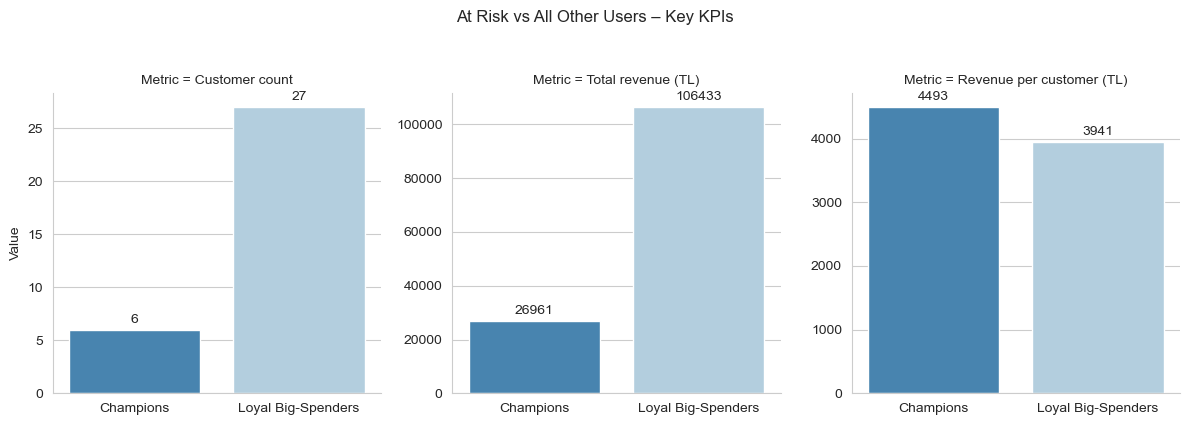

In [32]:
# plot

g = sns.catplot(data=plot_df,
                x='Segment', y='Value',
                col='Metric', kind='bar',
                palette='Blues_r',
                sharey=False, height=4, aspect=1)

g.fig.suptitle('At Risk vs All Other Users – Key KPIs', y=1.05)

# add value labels & clean axes
for ax in g.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f', padding=3)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

As seen above, the at-risk segment is comprised of almost the half of the whole user dataset. In addition, they are bringing more revenue than the rest of the users combined. The red flag here is that these users are not seen for some time already - their R_Score is <= 3. We need immediate action to bring those customers back, or else we will lose a significant amount of revenue in the mid-long run. 

## 3. How does customer behavior differ across the segments in terms of Recency, Frequency, and Monetary metrics?

So far, we have segmented our dataset to 6: 

- Champions
- Loyal Big Spenders
- Poteantial Loyalists
- Promising
- New Customers
- At-risk

Let's plot all of them:


Mean metrics by segment:

Metric               Frequency (Usage in Last 12 Months)  Recency  Total Spending (TL)
Segment                                                                               
At-Risk                                             30.0    282.0               2853.6
Champions                                           45.8     60.2               4493.5
Loyal Big-Spenders                                  39.6     69.3               3942.0
New Customers                                       11.1     61.2               1067.6
Potential Loyalists                                 35.7    102.1               1604.8
Promising                                           19.3    137.5               1349.6


/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/3865587435.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/3865587435.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/3865587435.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1940/3865587435.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

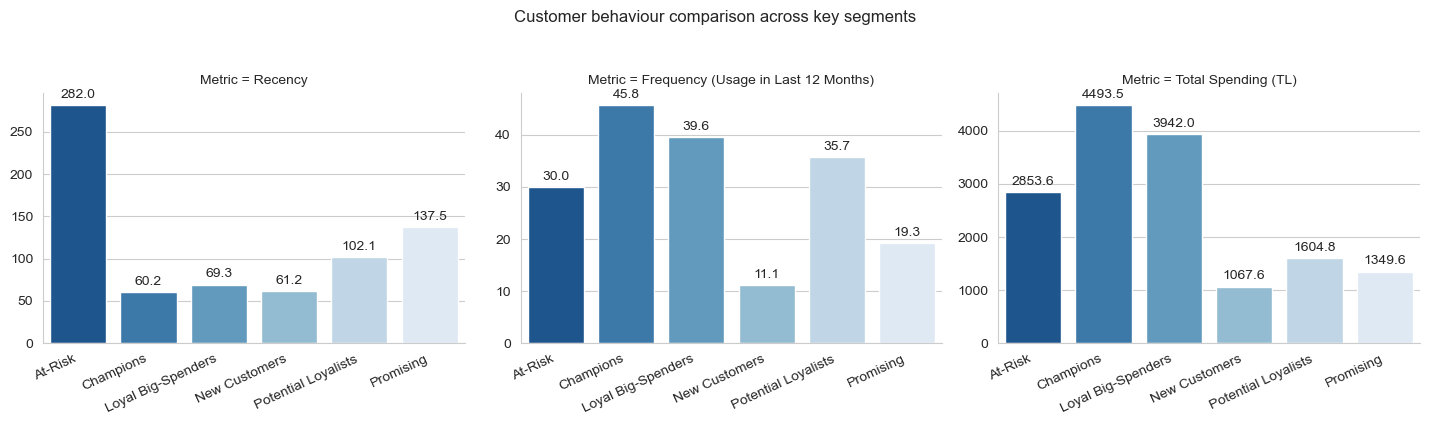

In [33]:
df['R_Score'] = pd.qcut(df['Recency'], 5, labels=[5,4,3,2,1])
df['F_Score'] = pd.qcut(df['Frequency (Usage in Last 12 Months)'], 5, labels=[1,2,3,4,5])
df['M_Score'] = pd.qcut(df['Total Spending (TL)'], 5, labels=[1,2,3,4,5])
df['RFM_Score'] = df['R_Score'].astype(str) + df['F_Score'].astype(str) + df['M_Score'].astype(str)

# ------- 2. Map rows to the requested segments ---------------------------
def label_segment(row):
    r, f, m, rfm = row['R_Score'], row['F_Score'], row['M_Score'], row['RFM_Score']
    if r==5 and f==5 and m==5: return 'Champions'
    if rfm in ['554','545','544','455']: return 'Loyal Big-Spenders'
    if r==5 and f<=2 and m<=2: return 'New Customers'
    if r>=4 and f>=3 and m<=3: return 'Potential Loyalists'
    if r>=4 and f==2 and m<=2: return 'Promising'
    if r<=3 and (f>=3 or m>=3): return 'At-Risk'
    return 'Others'

df['Segment'] = df.apply(label_segment, axis=1)

# keep only the six named segments
segments_of_interest = ['Champions','Loyal Big-Spenders','New Customers',
                        'Potential Loyalists','Promising','At-Risk']
seg_df = df[df['Segment'].isin(segments_of_interest)].copy()

# ------- 3. Aggregate mean metrics ---------------------------------------
metrics = ['Recency', 'Frequency (Usage in Last 12 Months)', 'Total Spending (TL)']
seg_mean = (seg_df.groupby('Segment')[metrics]
            .mean()
            .round(1)
            .reset_index()
            .melt(id_vars='Segment', var_name='Metric', value_name='Mean'))

# ------- 4. Table view ----------------------------------------------------
pivot_table = seg_mean.pivot(index='Segment', columns='Metric', values='Mean').round(1)
print("\nMean metrics by segment:\n")
print(pivot_table.to_string())

# ------- 5. Visual comparison --------------------------------------------

sns.set_style('whitegrid')

g = sns.catplot(
    data=seg_mean,
    x='Segment', y='Mean',
    col='Metric', kind='bar',
    palette='Blues_r',
    sharey=False,
    height=4, aspect=1.2     
)

g.fig.suptitle('Customer behaviour comparison across key segments', y=1.05)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
    
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.1f', padding=3)
    
    ax.set_xlabel('')   
    ax.set_ylabel('')   

plt.tight_layout()
plt.show()


### Behaviour Differences Across Key Segments  

| Segment | Recency&nbsp;*(days since last ride)* | Frequency&nbsp;*(rides / yr)* | Monetary&nbsp;*(TL / yr)* | Take-away |
|---------|:------------------------------------:|:-----------------------------:|:-------------------------:|-----------|
| **Champions** | **60** | **46** | **4 494** | Ride very recently and very often, spend the most — top VIPs. |
| **Loyal Big-Spenders** | 69 | 40 | 3 942 | Almost as active as Champions and still high spend; biggest single revenue block. |
| **Potential Loyalists** | 102 | 36 | 1 605 | Active and fairly frequent but mid-range spend → prime upsell targets. |
| **Promising** | 138 | 19 | 1 350 | Recent but only a few rides so far; early-stage habit to nurture. |
| **New Customers** | 61 | 11 | 1 068 | Very recent sign-ups with low usage & spend — activation window is now. |
| **At-Risk** | **282** | 30 | 2 854 | Historically valuable but inactive for 9 months; urgent win-back needed. |

**Key contrasts**

* **Recency:** Champions, Loyal Big-Spenders, and New Customers are all seen within the last 2 months, whereas At-Risk users haven’t opened the app for 9 months.
* **Frequency:** Champions ride the most (4 rides/month). Promising and New Customers are still below 2 rides/month.
* **Monetary:** Spend per rider drops sharply after Loyal Big-Spenders; Potential Loyalists and Promising have head-room to grow, while At-Risk still carry high historic spend despite long dormancy.

These averages highlight where to **retain (Champions, Loyal Big-Spenders), nurture (Potential Loyalists, Promising), activate (New Customers), and rescue (At-Risk)**.


# Step 3: Marketing Strategy

Before we start our suggestions, let's compare the R_score, F_score, and M_score of the segments so that we are backing up our suggestions with our findings. For example, we will not send push notifications such as "We miss you" to our high-value or emerging customers right off the bat. However, we'll do that for our churned / low-value customers. Let's take a look:

In [34]:
# --- add integer score columns ---------------------------------
df['R_int'] = df['R_Score'].astype(int)
df['F_int'] = df['F_Score'].astype(int)
df['M_int'] = df['M_Score'].astype(int)

# --- now build the KPI table -----------------------------------
kpi = (df.groupby('Segment')
        .agg(customers   = ('Customer ID', 'count'),
             revenue     = ('Total Spending (TL)', 'sum'),
             avg_R_score = ('R_int', 'mean'),
             avg_F_score = ('F_int', 'mean'),
             avg_M_score = ('M_int', 'mean'))
        .assign(rev_per_cust = lambda x: x['revenue'] / x['customers'],
                cust_share   = lambda x: x['customers'] / x['customers'].sum() * 100,
                rev_share    = lambda x: x['revenue']   / x['revenue'].sum()   * 100)
        .round(0)
        .astype(int)
        .reset_index()
        .sort_values('rev_share', ascending=False))

kpi.index = range(1, len(kpi) + 1)
display(kpi)


,Segment,customers,revenue,avg_R_score,avg_F_score,avg_M_score,rev_per_cust,cust_share,rev_share
1,At-Risk,497,1418236,2,3,3,2854,50,55
2,Others,293,761322,4,2,3,2598,29,30
3,Potential Loyalists,134,215039,5,4,2,1605,13,8
4,Loyal Big-Spenders,27,106433,5,4,4,3942,3,4
5,Champions,6,26961,5,5,5,4494,1,1
6,New Customers,31,33097,5,1,1,1068,3,1
7,Promising,12,16195,4,2,2,1350,1,1


## 1. High-Value Customers: How will you retain them and increase their loyalty?

Our High Value customers have been analyzed in two segments: Champions and Loyal Big Spenders. Here are some ideas to retain them and increase their loyalty:

- Automatic upgrade to a “BiTaksi Elite” status: priority driver assignment, and small monthly ride credits—keeps them feeling privileged and reduces churn risk.

- Gamification: “Hit ₺2 000 total spend this month and unlock 10 % off every 5th ride next month.”

- Personalised thank-you surprises: Quarterly surprise coupons (e.g., free airport transfer) tied to individual ride history; reinforces emotional loyalty at minimal cost.

- Let them test new features first (e-scooter, parcel delivery, etc.). Exclusivity deepens engagement and generates high-quality feedback.

- Offer prepaid 10/20-ride packs at 8 % discount. Locks in future trips and lifts upfront cash flow while increasing stickiness.

- Double referral credits for this tier; their social influence pulls in similar high-value riders and boosts network effects.

- Flag any Elite rider whose weekly rides drop >30 %. Trigger an automated “We miss you, here’s ₺50 off your next ride” push before loyalty erodes.


## 2. Churned or Low-Value Customers: What initiatives can re-engage these users?

This strategy targets At-Risk users (identified in our 6 key segments) and an additional slice of low-engagement users outside the priority clusters. Here are the initiative suggestions to re-engage these users: 

- “We Miss You” push with time-limited credits. Offer a ₺200 coupon valid for 3 days. Create urgency:
“Take your next ride by Friday and get ₺200 off – just for coming back.”

- Win-back email with personalised ride history: Highlight where and when they last rode:
“It’s been 8 months since your last trip from Kadıköy to Taksim. Ready to ride again?”

- First-ride reactivation bonus: For completely churned users, offer “₺100 off your first ride back” + double referral credits if they bring a friend.

- Budget-friendly ride bundles: Create 3-ride packs at discounted rates to reactivate price-sensitive users who might have switched to cheaper alternatives.

- Survey + credit combo: Ask why they stopped riding—offer ₺50 - ₺200 credit for feedback. Use insights to segment into price-sensitive, driver issues, app usability, etc.

- Push passive app users: Target users who still have the app installed but haven’t ridden:
“We’re still here. Need a lift?” + embedded quick-book CTA.


## 3. Emerging Customers: How can you convert them into high-value customers?

Coming back to our 6 segments, these emerging customers can be equated with Promising, Potential Loyalists, and New Customers. Below are some suggestions to convert these customers into high-value customers, such as Champions and Loyal Big Spenders.

For New Customers: 

- Welcome-back credit
₺100 bonus for taking a second ride within 3 days. This offer reinforces early momentum.

- Quick milestone challenge
“3 rides this week = ₺50 credit”, it builds habit in the first 7 days.

- Onboarding push series
In-app messages: “How to earn rewards faster” / “Tips for better driver matches”, founding familiarity and trust.

- Instant referral prompt
“Refer a friend after your first ride and get ₺250 each”, turning early curiosity into growth.

For Promising & Potential Loyalists:

- Ride-based progression offers: “You’re 2 rides away from unlocking BiTaksi Plus benefits”. This initiative leverages near-term action.

- Ride bundle packs: Offer discounted 5- or 10-ride bundles to increase frequency and lock in usage.

- Tiered loyalty rewards: Introduce silver/gold tiers with benefits (e.g. faster matching, bonus credits every 10 rides).

- Monthly spend incentive: “Spend ₺1500 this month, get ₺200 credit next month”. This one encourages consistent usage and higher spend.

Geo-personalized Initiative Pool for both New Customers and Promising & Potential Loyalists:

- “Night Rider” Credit (Kadıköy, Beşiktaş, Taksim)
₺30 off on rides after 22:00 — targets nightlife movement and FOMO.

- Weekend Corridor Bonus (Kızılay - Yenimahalle)
Complete 3 rides between Friday–Sunday = ₺75 credit — boosts weekend repeat usage.

- Pier Handoff Promo (Istanbul) “Catching a ferry from Beşiktaş or Kadıköy? Get ₺25 off your next ride to the pier.”
Promotes short, high-frequency city rides.

- After-Class Deal (Bilkent, Ege, ITU, etc.)
₺30 off after 19:00 from university zones — hooks students into evening ride patterns.

- Rain Ride Reward (Alsancak, Nişantaşı, etc.) Automatic ₺40 off when local forecast shows rain.
High perceived value when walking is less desirable. Prompts such as  "It's pouring in Alsancak — enjoy ₺40 off your next BiTaksi ride today. Stay dry, stay moving. Offer valid until midnight."

- First Ride from Airport (Istanbul, Ankara, İzmir)
₺100 off for new or returning users from Sabiha, Esenboğa, or Adnan Menderes.

- Last Location Push: “We missed you in Moda! Here’s ₺40 off your next pickup from there.”





## 4. When it comes to campaign activities, what can be done to grow the base of both the passengers and drivers of BiTaksi to make the most out of the budget that we have?

Firstly, let's decide how much of our budget will go to the passengers and the drivers:
 
Money invested in passengers must come back faster than the money spent on drivers. A new passenger usually earns back their acquisition cost in just 2–3 trips and keeps generating revenue, while recruiting additional drivers only helps if demand is already outgrowing the supply.

Since BiTaksi’s main cities have short waiting times, stimulating demand must  be the bigger profit lever. Therefore, let's allocate **75% of the budget to passenger growth**, while investing **25% to driver initiatives** to maximize return while still keeping our supply healthy.



### 4.1. Passenger Campaign Budget Allocation 

Idea #1: Look-alike ads seeded with “Champions” & “Loyal Big-Spenders” (Meta, Google, TikTok)

- 35 % of the budget will go here.
- Reason: Scales fastest; seed cohort keeps CAC 20-40 % below broad targeting.

Idea #2: Dynamic geo-fence bursts (concerts, derbies, festival zones)

- 20 % of the budget will go here.
- Reason: 48-hour, high-intent spikes. CPM is approx. 30 % under always-on citywide spend.

Idea #3: Streak-based refer-a-friend program (₺40 on ride 1, ₺100 after ride 3)

- 20 % of the budget will go here.
- Reason: Virtually zero media cost; turns existing passengers into recruiters while boosting early-life frequency.


Idea #4: Airports & airlines bundle (IST, SAW terminals + Turkish Airlines boarding-pass e-mails)	

- 15 % of the budget will go here.
- Reason: Captures tourists/business travellers at the exact “need-a-ride” moment; higher fare sizes offset partnership fees.


Idea #5: Quick-commerce cross-promo (Getir, Yemeksepeti, Trendyol Go)

- 10 % of the budget will go here.
- Reason: Each grocery/food order receipt shows a unique Bitaksi first-ride code; partners co-fund incentives, tapping millions of high-frequency, app-savvy users at minimal CAC.




### 4.2. Driver Campaign Budget Allocation

Idea #1: WhatsApp click-to-chat lead ads (targeted to plate registry + churned drivers)

- 35 % of the budget will go here.
- Cheapest proven source of qualified drivers—2-3× higher conversion than broad social ads, so every lira pulls in more activated supply.

Idea #2: ₺500 fuel-card bonus after first 20-ride streak

- 30 % of the budget will go here.
- Pays out only when the driver is fully active, turning cost into guaranteed revenue while enticing dormant high-rated drivers to return.

Idea #3: Weekly gamified leaderboard & fuel draw for top 10 %	

- 15 % of the budget will go here.
- Small cash outlay, big psychological lift; increases online hours and keeps CSAT high without scaling costs.

Idea #4: In-app 30-minute hot-zone heat-map guidance	

- 10 % of the budget will go here.
- Product tweak, not media spend—helps drivers earn more per hour, boosting retention for pennies.

Idea #5: Experiment pot (fuel-station pop-ups, micro-influencer drivers, etc.)

- 10 % of the budget will go here.
- Funds 1-2 quick pilots per quarter; scale or kill fast based on cost-per-activated-driver vs. baseline.

## 5. At BiTaksi, what initiatives can be taken in order to decrease the churn rate of the passengers and drivers?

### 5.1. Passenger Churn Reduction Initiatives 

Let's first start with BiTaksi passengers. We have already segmented them into 6 groups:

- Champions (highest R + F + M)
- Loyal Big-Spenders 
- New Customers
- Potential Loyalists
- Promising 
- At Risk (R 1-2, low F)


#### 5.1.1. Churn Reduction Initiatives for Champions

- Priority Pickup + Fare-Freeze: if ETA > 10 min, ₺100 auto-credit
- 48-hour “We-Miss-You” bonus: ₺100 ride credit the moment the 7-day gap hits
- VIP Early-Access Pack: bundle of new features + partner lounge voucher (ex. Turkish Airlines Istanbul Airport Lounge)

#### 5.1.2. Churn Reduction Initiatives for Loyal Big-Spenders	

- 5-ride cash-back streak: earn ₺100 back when completing 5 surge-priced rides
- Dedicated WhatsApp concierge with 5-min SLA ＋ ₺250 goodwill credit on unresolved issues
- Spend milestone: free airport ride (≈ ₺100+) after every ₺1 500 monthly spend

#### 5.1.3. Churn Reduction Initiatives for New Customers

- “3-ride bundle”: ₺100 total discount split across rides 2-4
- Gamified progress bar: unlock ₺150 bonus credit after first 3 rides
- Welcome survey reward: ₺75 personalised voucher for completing a 1-minute survey

#### 5.1.4. Churn Reduction Initiatives for Potential Loyalists

- Commute-hour vouchers: ₺100 off split across next AM & PM rides
- Ride-10 celebration: ₺100 credit when hitting 10 lifetime rides
- Smart reminder: ML-timed push offering ₺50 cashback if they ride within 24 h

#### 5.1.5. Churn Reduction Initiatives for Promising

- Fare-lock preview + next-10-min price forecast
- Off-peak credit: ₺50 auto-sent after 2 searches w/o booking
- “Price-drop” alert: push when surge subsides, bundling ₺75 coupon (Use the coupon code DROP75)

#### 5.1.6. Churn Reduction Initiatives for At-Risk

- “Mega Come-Back Bundle”: Push + e-mail: “We’ve missed you! Enjoy ₺150 credit spread over your next 3 rides (₺50 each). Expires in 10 days.” 
- Free airport or intercity ride. Voucher: “One FREE ride up to ₺200 anywhere—including IST or SAW—valid 30 days.”
- “Gift a Ride” double bonus. Push: “Share Bitaksi with a friend—both of you get ₺200. Your code expires in 7 days.”
- “Weekend Duo Pack”: Push + e-mail: “Ride back with Bitaksi! This weekend you get 2 free rides, up to ₺150 each (₺300 total). Activate with one tap—offer valid Fri 18:00 - Sun 23:59.”

### 5.2. Driver Churn Reduction Initiatives 

Let's segment our drivers to 6 groups as well:

- Elite Earners
(Top 10 % by rides & rating ≥ 4.8)
- Consistent Pros
(Rating ≥ 4.6, 40-80 rides/wk)
- New Drivers
(≤ 30 days on platform)
- Dormant High-Rated
(Inactive ≥14 days, rating ≥ 4.7)
- At-Risk
(Online hours ↓ 30 % & cancel rate ↑ > 5 pp)
- Low-Rating
(Rating < 4.5)

#### 5.2.1. Churn Reduction Initiatives for Elite Earners

- Priority dispatch for airport / long-haul jobs all week.
- ₺400 fuel e-card when they match last week’s ride count.
- Invite-only “Pro Club” WhatsApp line—human help < 3 min.

#### 5.2.2. Churn Reduction Initiatives for Consistent Pros

- ₺500 fuel top-up after a 50-ride streak.
- Heat-map tips pushed daily at shift start.
- 50 % service-fee holiday for the next 25 rides.

#### 5.2.3. Churn Reduction Initiatives for New Drivers

- On-boarding coach call + ₺60 fuel voucher when call finished.
- “First-50” badge + extra ₺100 after 50 rides.
- Guaranteed floor – ₺350/day if they accept ≥90 % of jobs.

#### 5.2.4. Churn Reduction Initiatives for Dormant High-Rated

- Reactivation bundle – ₺750 fuel after 30 rides in 10 days.
- WhatsApp Doc-Refresh – send a personalised link; driver snaps photos of any expired papers in chat, OCR + staff verify within 15 min, and we top-up ₺20 mobile data for their trouble.
- “Queue-jump” pass for first 5 rides back.

#### 5.2.5. Churn Reduction Initiatives for At-Risk



- Cancel-fee buffer: first 10 cancellations free (approx. ₺100 value).
- SIM-Data ＋ Coffee Boost: finish 30 rides in 7 days and get a ₺150 data top-up plus a free coffee voucher at partner petrol stations.
- Peak-Hour Earnings Booster: for the next 20 rides accepted during weekday peaks (07-10 & 17-20), Bitaksi adds ₺6 extra per ride (max ₺120).

#### 5.2.6. Churn Reduction Initiatives for Low-Rating



- Free customer-service micro-course; complete: ₺100 bonus.
- Temporary pairing with high-rated zones (safer passengers).
- Progress badge: earn back full dispatch access after 10 five-star rides; extra ₺250 bonus.

## 6. What are the areas to improve for BiTaksi and the areas that it dominates the market, when we compare it to its competitors? 

When we look at the recent market, as of June 2025, we see three competitors for BiTaksi: Uber, Martı TAG and Yandex Go. Dimension by dimension, let's investigate where BiTaksi is stronger, but also have a keen eye on its competitors' recent moves.

### Dimension #1: Geographic Reach

#### What BiTaksi already does better than the rest:

Operates in 24 Turkish cities, from İstanbul to Gaziantep. BiTaksi is the only private-sector app with true nationwide coverage.

#### Where rivals have the edge / what BiTaksi should fix:


- Uber is now live in just 6–7 big cities (İstanbul, Ankara, İzmir, Bursa, Kayseri, Adana). Martı and Yandex Go are still regional, but their growth stories show they can scale fast. (Martı +12 % riders QoQ, Yandex Go expanding beyond Antalya, especially along the Mediterranean region).

- BiTaksi definitely should keep a close eye on these initiatives. It should not take its leading position for granted and immediately push for geo-based initiatives. On geo-based intiatives, here are some ideas to implement: 

-- “Night Rider” Credit (Kadıköy, Beşiktaş, Taksim)
₺30 off on rides after 22:00 — targets nightlife movement and FOMO.

-- Weekend Corridor Bonus (Kızılay - Yenimahalle)
Complete 3 rides between Friday–Sunday = ₺75 credit — boosts weekend repeat usage.

-- Pier Handoff Promo (Istanbul) “Catching a ferry from Beşiktaş or Kadıköy? Get ₺25 off your next ride to the pier.”
Promotes short, high-frequency city rides.

-- After-Class Deal (Bilkent, Ege, ITU, etc.)
₺30 off after 19:00 from university zones — hooks students into evening ride patterns.

-- Rain Ride Reward (Alsancak, Nişantaşı, etc.) Automatic ₺40 off when local forecast shows rain.
High perceived value when walking is less desirable. Prompts such as  "It's pouring in Alsancak — enjoy ₺40 off your next BiTaksi ride today. Stay dry, stay moving. Offer valid until midnight."

-- First Ride from Airport (Istanbul, Ankara, İzmir)
₺100 off for new or returning users from Sabiha, Esenboğa, or Adnan Menderes.

-- Last Location Push: “We missed you in Moda! Here’s ₺40 off your next pickup from there.”




### Dimension #2: Payment stack & UX extras	

#### What BiTaksi already does better than the rest:

- Card-on-file, cash, Masterpass wallet; in-app fare estimate.
- Pet-friendly “Pati Taksi”; 24/7 phone support.

#### Where rivals have the edge / what BiTaksi should fix:


- ₺50 service fee on every İstanbul trip angers riders and is called a “hidden cost” in FAQ and complaints.

Competitors will most likely go after this and build a workaround to market something like "no hidden cost", etc. BiTaksi should do a detailed analysis on this specific issue and analyze how it is impacting their churn. It is definitely an issue to be addressed since data shows that it is a common customer complaint. The anecdota and data are strong with this one.

### Dimension #3: Payment stack & UX extras

#### What BiTaksi already does better than the rest:

- Large yellow-taxi fleet; drivers can keep cash or card tips, no need to buy special plates; nationwide demand.	

#### Where rivals have the edge / what BiTaksi should fix:

- Martı TAG markets zero commission (“Martı hiçbir komisyon almaz”) which is attractive to drivers. 
- Offering temporary fee holidays or loyalty rebates would blunt that message.

### Dimension #4: Tourist Friendliness

#### What BiTaksi already does better than the rest:

- Smooth English UI experience, fare shown before pickup; hotline helps visitors unfamiliar with the city.	

#### Where rivals have the edge / what BiTaksi should fix:

- Yandex Go arrived with multilingual TR/EN/RU interface and cash-or-card flexibility that specifically targets Russian-speaking tourists on the Mediterranean coast.
- Adding Russian-language support in the BiTaksi UI (and airport kiosks) would close this gap.

### Dimension #5: Brand & Trust

#### What BiTaksi already does better than the rest:

- A decade-old brand with 100 M+ completed rides and top-of-mind awareness.

#### Where rivals have the edge / what BiTaksi should fix:

- Peak-time acceptance gaps: complaints of 15-20 min waits or driver cancellations fill ŞikayetVar boards and push disgruntled riders to Uber.
- A supply-side SLA (e.g., ₺50 credit if ETA > 8 min) would turn a weakness into an NPS win.

### Dimension #5: Brand & Trust

#### What BiTaksi already does better than the rest:

- Works only with licensed yellow taxis, avoiding the legal battles that once sidelined Uber, Martı, etc.

#### Where rivals have the edge / what BiTaksi should fix:

- Martı TAG just won a lawsuit that keeps its “car-pool” model legal and fee-free, potentially eroding BiTaksi’s driver pool in İstanbul. Uber, on the other hand, is back, and coming big.

### Conclusion:

BiTaksi’s national footprint, rich payment options, and decade of brand equity are real moats, but volume-draining pain points—service fee perception, peak-hour supply, tourist language support, and geo-based moves by its competitors are exactly where Uber, Martı and Yandex Go are attacking. Fixing those few gaps will turn BiTaksi’s size advantage into a decisive market lead.

## 7. What are the possible passenger and driver segments for BiTaksi? 

Earlier, with the dataset that we have, we segmented our passengers into 6 groups:

- Champions (highest R + F + M)
- Loyal Big-Spenders 
- New Customers
- Potential Loyalists
- Promising 
- At Risk (R 1-2, low F)

For detailed exploration of these segments, please refer to the header titled "Analyze the Segments"


Later, we supposed 6 segments for drivers as well and named them the following: 

- Elite Earners
(Top 10 % by rides & rating ≥ 4.8)
- Consistent Pros
(Rating ≥ 4.6, 40-80 rides/wk)
- New Drivers
(≤ 30 days on platform)
- Dormant High-Rated
(Inactive ≥14 days, rating ≥ 4.7)
- At-Risk
(Online hours ↓ 30 % & cancel rate ↑ > 5 pp)
- Low-Rating
(Rating < 4.5)

We can suppose their characteristics as below:

**Elite Earners – top 10 % by rides, rating ≥ 4.8**

* Online every rush-hour, know all hot-zones, rarely cancel.
* Prioritise income per hour and tip frequency; happiest when they get airport or long-haul fares.
* Expect instant support; any downtime or app glitch annoys them fast.

**Consistent Pros – rating ≥ 4.6, 40-80 rides/week**

* The operational backbone: dependable, polite, but still hunting for better net earnings.
* Fuel and data costs are constant stressors; small bonuses or commission rebates move the needle.
* Open to coaching on heat-map use, surge timing, and upsell tips.

**New Drivers – ≤ 30 days on the platform**

* Still juggling document uploads, first cancellation penalties, and learning the dispatch rhythm.
* Biggest fears: low ratings, unfamiliar routes, and wasting fuel while waiting.
* Quick wins are clear onboarding checklists, “first-50 rides” bonuses, and real-time chat help.

**Dormant High-Rated – inactive ≥ 14 days, rating ≥ 4.7**

* Often parked due to expired paperwork, seasonal travel, or testing a rival app.
* Will return for easy admin fixes and a burst of guaranteed, high-fare trips.
* Care more about immediate ride flow than one-off cash gifts.

**At-Risk – hours down 30 % and cancel rate up 5 pp**

* Burning out on low-fare jobs, traffic, or repeated rider no-shows.
* Penalty anxiety makes them switch off rather than risk more fees.
* Data top-ups, cancel-fee buffers, and peak-hour per-ride boosts keep them engaged.

**Low-Rating – rating < 4.5**

* Struggle with customer etiquette, route disputes, or vehicle cleanliness.
* Afraid of de-activation but unsure how to improve.
* Respond well to bite-size service tips, recovery badges, and small bonuses tied to five-star streaks.
